In [1]:
import os
import numpy as np
import pandas as pd
import torch as t
from torch import nn

# BehaviorNet in PyTorch

Using a simple LSTM network to learn activities representations (activity embedding analog to a word embedding in a language model).

In [2]:
device = t.device('cpu')

## Load and prepare the artifical logfiles

In [3]:
%%bash
ls -lisa ./Data

total 33408
8604356875     0 drwxr-xr-x   6 matthiasgroncki  staff       192 Nov 10 20:43 .
8604356849     0 drwxr-xr-x  13 matthiasgroncki  staff       416 Nov 10 21:01 ..
8604356877     8 -rw-r--r--   1 matthiasgroncki  staff       384 Nov 10 20:53 id2action.npy
8604364278 19944 -rw-r--r--   1 matthiasgroncki  staff  10207313 Nov 10 20:53 logfile.pkl
8604356876  9256 -rw-r--r--   1 matthiasgroncki  staff   4736465 Nov 10 16:12 logfile_fraudulent_activities.pkl
8604356878  4200 -rw-r--r--   1 matthiasgroncki  staff   2147215 Nov  8 16:10 logfile_v1.pkl


In [4]:
logfile = pd.read_pickle('./Data/logfile.pkl')

In [5]:
id2action = np.load('./Data/id2action.npy')
action2id = {a : i for i,a in enumerate(id2action)}

In [6]:
logfile['SessionActivityInt'] = logfile.SessionActivity.map(lambda ls: np.array([action2id[a] for a in ls]+[action2id['start']]))

In [7]:
logfile.head()

,UserID,Day,UserSessionId,SessionActivity,UserRole,PotentialFraudster,FraudulentActivity,SessionActivityInt
0,0,0,1,"[start, action_1, action_5, action_1, end]",0,0,0,"[1, 3, 7, 3, 2, 1]"
1,0,0,1,"[start, action_1, action_3, end]",0,0,0,"[1, 3, 5, 2, 1]"
2,0,0,1,"[start, action_1, action_3, action_2, action_2...",0,0,0,"[1, 3, 5, 4, 4, 2, 1]"
3,0,0,1,"[start, action_4, end]",0,0,0,"[1, 6, 2, 1]"
4,0,0,1,"[start, action_2, action_2, action_1, action_4...",0,0,0,"[1, 4, 4, 3, 6, 4, 2, 1]"


## Network Design

In [8]:
class VerySimpleBehaviorNet(nn.Module):
    '''
    Very simple network consisting of an embedding layer, LSTM layers and a decoder with dropouts
    '''
    def __init__(self, n_actions=6, embedding_size=3, n_nodes=6, n_layers=2, dropout=0.2, 
                 padding_idx=0, initrange=0.5):
        super(VerySimpleBehaviorNet, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.embedding = nn.Embedding(n_actions, embedding_size, padding_idx)
        self.rnn = nn.LSTM(embedding_size, n_nodes, n_layers, dropout=dropout)
        self.decoder = nn.Linear(n_nodes, n_actions)
        self.init_weights(initrange)
        self.n_nodes = n_nodes
        self.n_layers = n_layers
        
    def init_weights(self, initrange=0.1):
        self.embedding.weight.data.uniform_(-initrange, initrange)
        # Set the first row to zero (padding idx)
        self.embedding.weight.data[0,:] = 0
        print(self.embedding.weight)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
        
    def init_hidden(self, batch_size):
        weight = next(self.parameters())
        return (weight.new_zeros(self.n_layers, batch_size, self.n_nodes),
                weight.new_zeros(self.n_layers, batch_size, self.n_nodes))
    
    def forward(self, input, hidden):
        emb = self.dropout(self.embedding(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.dropout(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

In [9]:
def get_batch(i, batch_size, input):
    '''
    Takes a column/list of activity tensors of variable lenght
    and returns the padded i-th minibatch of batch_size activities 
    '''
    data = input[i*batch_size : (i+1) * batch_size]
    data = sorted(data, key=len, reverse=True)
    x = nn.utils.rnn.pad_sequence([x[:-1] for x in data])
    y = nn.utils.rnn.pad_sequence([y[1:] for y in data])
    return x, y

In [10]:
def split_train_test(input, device, prop=0.8, seed=42):
    np.random.seed(42)
    mask = np.random.uniform(size=input.shape[0])<=prop
    train = input[mask]
    test = input[~mask]
    train = [t.LongTensor(a).to(device) for a in train]
    test = [t.LongTensor(a).to(device) for a in test]
    return train, test, input[mask].index, input[~mask].index

In [11]:
train, test, train_idx, test_idx = split_train_test(logfile.SessionActivityInt, device)

In [33]:
get_batch(0, 2, train)

(tensor([[ 1,  1],
         [ 3,  3],
         [ 5,  7],
         [ 4,  3],
         [ 4,  2],
         [ 2,  0]]), tensor([[ 3,  3],
         [ 5,  7],
         [ 4,  3],
         [ 4,  2],
         [ 2,  1],
         [ 1,  0]]))

In [13]:
def training(model, optimizer, scheduler, loss_function, data, batch_size, n_actions, clipping=0.5):
    model.train()
    n_batch = int(np.ceil(len(data) // batch_size))
    hidden = model.init_hidden(batch_size)
    scheduler.step()
    total_loss = 0.0
    for batch in range(n_batch):
        hidden = tuple(h.detach() for h in hidden)
        x,y = get_batch(batch, batch_size, data)
        optimizer.zero_grad()
        output, hidden = model(x, hidden)
        output_flatten = output.view(-1, n_actions)
        y_flatten = y.view(-1)
        loss = loss_function(output_flatten, y_flatten)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clipping)
        optimizer.step()
        total_loss += loss
    return total_loss / n_batch

def evaluate(model, loss_function, data, n_actions):
    model.eval()
    batch_size = len(data)
    hidden = model.init_hidden(batch_size)
    x,y = get_batch(0, batch_size, data)
    output, hidden = model(x, hidden)
    output_flatten = output.view(-1, n_actions)
    y_flatten = y.view(-1)
    loss = loss_function(output_flatten, y_flatten)
    y_probs = nn.Softmax()(output)
    y_predict = t.argmax(output, 2)
    y_predict[y==0]=0
    acc = (y_predict==y).double()[y>0].sum() / y[y>0].size(0)
    return y_probs, y_predict, y, loss, acc
    

## Training

In [14]:
modelname = 'model_1'
model = VerySimpleBehaviorNet(initrange=10, n_layers=2, n_nodes=20, n_actions=len(id2action)).to(device)
loss_func = nn.CrossEntropyLoss(ignore_index=0)
optimizer = t.optim.RMSprop(model.parameters(), lr=0.05)
scheduler = t.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000],
        [-6.2815,  3.5268,  5.5929],
        [ 9.7471, -7.4291, -8.6647],
        [ 0.6762,  6.9124,  2.1087],
        [ 7.2199,  6.3927, -7.9029],
        [-7.5845,  1.7843,  5.4995],
        [ 0.4824,  9.6483,  0.6643],
        [-0.5079, -0.2595,  1.9176]])


In [15]:
for epoch in range(20):
    training_loss = training(model, optimizer, scheduler, loss_func, train, 100, n_actions=len(id2action))
    y_prob, y_pred, y_true, test_loss, test_acc = evaluate(model, loss_func, test, n_actions=len(id2action))
    print(f'Epoch {epoch}\nTrain Loss : {training_loss} \t Val loss: {test_loss} \t Val Acc {test_acc}')

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0
Train Loss : 1.279161810874939 	 Val loss: 1.1077827215194702 	 Val Acc 0.5601578522155242
Epoch 1
Train Loss : 1.0879151821136475 	 Val loss: 1.0997117757797241 	 Val Acc 0.5584177490522653
Epoch 2
Train Loss : 1.0670135021209717 	 Val loss: 1.1000773906707764 	 Val Acc 0.5585109688645827
Epoch 3
Train Loss : 1.059635043144226 	 Val loss: 1.102400541305542 	 Val Acc 0.5585109688645827
Epoch 4
Train Loss : 1.0622659921646118 	 Val loss: 1.0977075099945068 	 Val Acc 0.5585109688645827
Epoch 5
Train Loss : 1.0478098392486572 	 Val loss: 1.100082278251648 	 Val Acc 0.5585109688645827
Epoch 6
Train Loss : 1.0444062948226929 	 Val loss: 1.0970730781555176 	 Val Acc 0.5585109688645827
Epoch 7
Train Loss : 1.0440216064453125 	 Val loss: 1.0995758771896362 	 Val Acc 0.5585109688645827
Epoch 8
Train Loss : 1.0438061952590942 	 Val loss: 1.0977249145507812 	 Val Acc 0.5585109688645827
Epoch 9
Train Loss : 1.0423400402069092 	 Val loss: 1.0983314514160156 	 Val Acc 0.5585109688645827
Epoc

## Save the model

In [16]:
try:
    os.mkdir('./models')
except Exception as e:
    print('Model dir already exists')

Model dir already exists


In [17]:
model_state_dict = model.state_dict()
optimizer_state_dict = optimizer.state_dict()

t.save({
     'epoch': epoch,
     'model_state_dict': model.state_dict(),
     'optimizer_state_dict': optimizer.state_dict(),
     'loss': training_loss,
}, f'./models/{modelname}')


In [18]:
model_state_dict

OrderedDict([('embedding.weight', tensor([[  0.0000,   0.0000,   0.0000],
                      [ -8.9003,   1.6843,  11.5321],
                      [ 16.8758, -10.0640, -16.4329],
                      [ -6.4948,   2.7890,   6.1408],
                      [  1.9356,   7.6334,  -0.8291],
                      [ -2.6455,  -1.4399,   0.2507],
                      [ -0.1580,  16.7551,   2.3649],
                      [ -0.6923,   0.3770,   0.6921]])),
             ('rnn.weight_ih_l0', tensor([[ -2.0007,  -1.9878,   2.3239],
                      [ -0.3635,   5.7221,   1.7977],
                      [  0.4733,  -1.0597,  -0.9656],
                      [  1.4725,  -1.1301,   0.7309],
                      [ -0.8671,   5.1503,   0.5093],
                      [  4.2750,   0.2573,  -2.6883],
                      [  1.4667,   0.1036,  -0.9996],
                      [ -1.0039,   0.0542,   0.8465],
                      [  0.9465,  -0.9559,  -1.5242],
                      [ -5.5367,  -1.06

## Use Embedding to detect anomalies

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

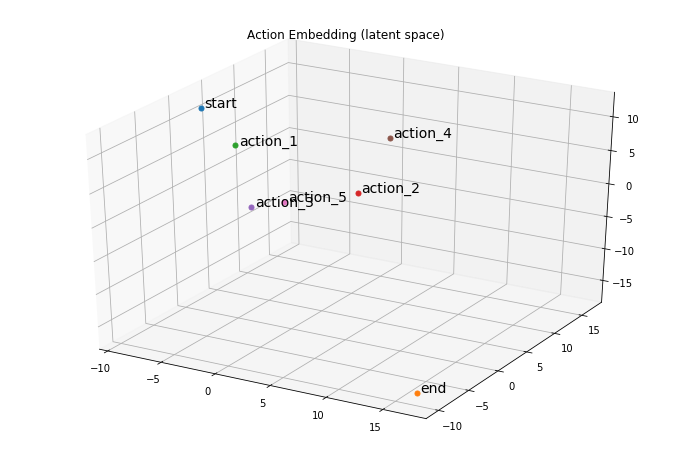

In [30]:
embeddings = model.embedding.weight.data.cpu().numpy()
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
for i in range(1, len(action2id)):
    ax.scatter(embeddings[i,0], embeddings[i,1], embeddings[i,2], s=25)
    ax.text(embeddings[i,0]+0.2, embeddings[i,1]+0.2, embeddings[i,2], s=id2action[i], fontsize=14)
    ax.grid(True)
ax.set_title('Action Embedding (latent space)')
plt.savefig('action_embeddings.png', dpi=500)

In [21]:
logfile['Embedded_Activities'] = logfile.SessionActivityInt.map(lambda x: embeddings[x].mean(axis=0))
logfile['Embedded_Activities_x'] = logfile.Embedded_Activities.map(lambda x: x[0])
logfile['Embedded_Activities_y'] = logfile.Embedded_Activities.map(lambda x: x[1])
logfile['Embedded_Activities_z'] = logfile.Embedded_Activities.map(lambda x: x[2])

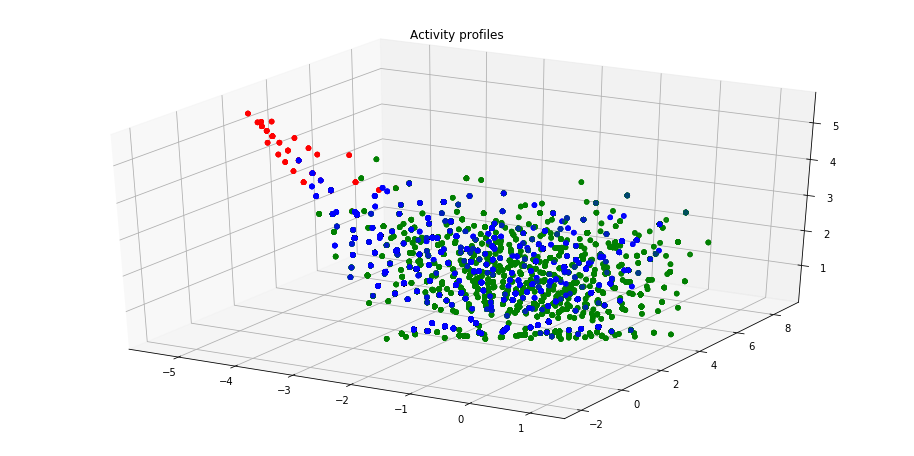

In [31]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('Activity profiles')
for i in range(1, len(action2id)):
    ax.scatter(logfile.loc[(logfile.FraudulentActivity==0) & (logfile.UserRole==0), 'Embedded_Activities_x'], 
               logfile.loc[(logfile.FraudulentActivity==0) & (logfile.UserRole==0), 'Embedded_Activities_y'], 
               logfile.loc[(logfile.FraudulentActivity==0) & (logfile.UserRole==0), 'Embedded_Activities_z'], color='green')
    ax.scatter(logfile.loc[(logfile.FraudulentActivity==0) & (logfile.UserRole==1), 'Embedded_Activities_x'], 
               logfile.loc[(logfile.FraudulentActivity==0) & (logfile.UserRole==1), 'Embedded_Activities_y'], 
               logfile.loc[(logfile.FraudulentActivity==0) & (logfile.UserRole==1), 'Embedded_Activities_z'], color='blue')
    ax.scatter(logfile.loc[logfile.FraudulentActivity==1, 'Embedded_Activities_x'], 
               logfile.loc[logfile.FraudulentActivity==1, 'Embedded_Activities_y'], 
               logfile.loc[logfile.FraudulentActivity==1, 'Embedded_Activities_z'], color='red')
    
    ax.grid(True)
plt.savefig('activityprofiles.png', dpi=500)

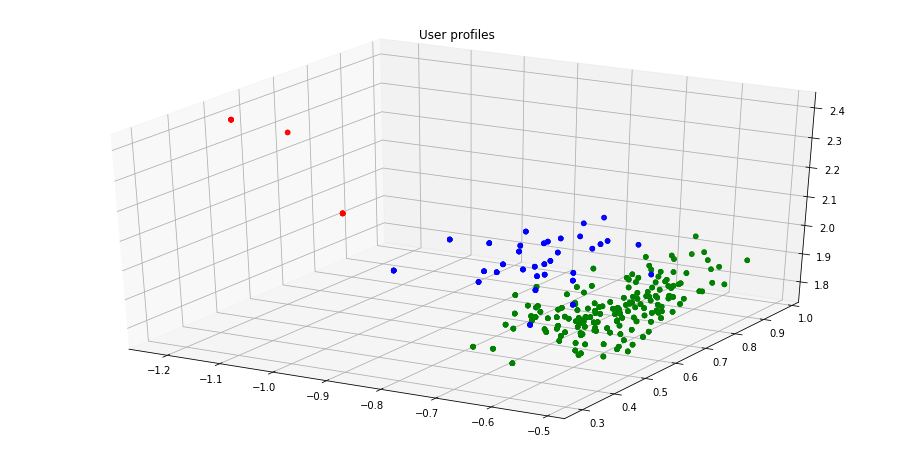

In [32]:
user_profiles = logfile.groupby(['UserID', 'UserRole', 'PotentialFraudster'], as_index=False).agg({
    'Embedded_Activities_x':np.mean,
    'Embedded_Activities_y':np.mean,
    'Embedded_Activities_z':np.mean,
})

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('User profiles')
for i in range(1, len(action2id)):
    ax.scatter(user_profiles.loc[(user_profiles.UserRole==0) & (user_profiles.PotentialFraudster==0), 'Embedded_Activities_x'], 
               user_profiles.loc[(user_profiles.UserRole==0) & (user_profiles.PotentialFraudster==0), 'Embedded_Activities_y'], 
               user_profiles.loc[(user_profiles.UserRole==0) & (user_profiles.PotentialFraudster==0), 'Embedded_Activities_z'], color='green')
    ax.scatter(user_profiles.loc[(user_profiles.UserRole==1) & (user_profiles.PotentialFraudster==0), 'Embedded_Activities_x'], 
               user_profiles.loc[(user_profiles.UserRole==1) & (user_profiles.PotentialFraudster==0), 'Embedded_Activities_y'], 
               user_profiles.loc[(user_profiles.UserRole==1) & (user_profiles.PotentialFraudster==0), 'Embedded_Activities_z'], color='blue')
    ax.scatter(user_profiles.loc[user_profiles.PotentialFraudster==1, 'Embedded_Activities_x'], 
               user_profiles.loc[user_profiles.PotentialFraudster==1, 'Embedded_Activities_y'], 
               user_profiles.loc[user_profiles.PotentialFraudster==1, 'Embedded_Activities_z'], color='red')
    ax.grid(True)
plt.savefig('userprofiles.png', dpi=500)